In [74]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az

In [2]:
p_grid = np.linspace(0, 1, 1001)
obs = [0, 1, 1, 0, 0]
prior = np.array([1/1001]*1001)

In [3]:
likelihood = [bernoulli.pmf(ob, p_grid) for ob in obs]

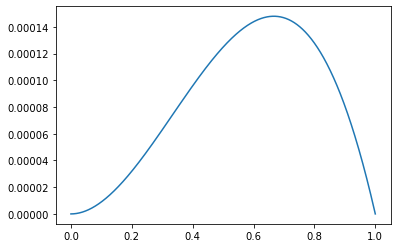

In [4]:
plt.plot(p_grid, prior*likelihood[0]*likelihood[1]*likelihood[2])

In [5]:
hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv", header=0)

# Removing auto measures
auto_measures = [c for c in hoyle_data.columns if c[:2] == "c_"] + ["u_mass_full"]
hoyle_data = hoyle_data.drop(columns = auto_measures)
hoyle_data.head(5).T

# Subsetting by intrusion task
d = hoyle_data[hoyle_data["task"]=="intrusions"]

In [18]:
# Creating unique identifier for each topic

unique_topic_ids = (d.groupby(["dataset", "model", "topic_idx"], as_index=False)
    .agg({"task":"count"})
    .drop(columns="task"))

unique_topic_ids["m_topic"] = unique_topic_ids.index

d1 = pd.merge(d, unique_topic_ids, on=["dataset", "model", "topic_idx"], how="left")

In [21]:
# Setting up numpy arrays for pymc
topics = np.array(d1["m_topic"])
n_topics = d1["m_topic"].nunique()
scores = np.array(d1["scores_raw"])

In [63]:
t_only_model = pm.Model()
with t_only_model:
    # Setting topic log odd prior to be N(0,1.5)
    a = pm.Normal("a", mu=0, sigma=1.5, shape=n_topics)
    p = pm.math.invlogit(a[topics])
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=scores)
    
    i_data=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


In [64]:
i_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

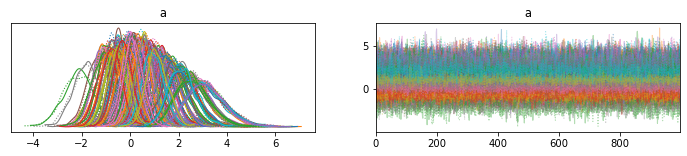

In [65]:
az.plot_trace(i_data)

In [66]:
trace = i_data.to_dataframe()

In [68]:
t = trace[["chain", "draw"]+[c for c in trace.columns if c[0]=="posterior"]]

/home/roger/anaconda3/envs/thesis/lib/python3.10/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


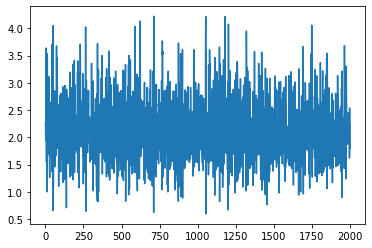

In [69]:
plt.plot(t[("posterior", "a[299]", 299)])

In [70]:
t.mean(axis="rows").sort_values()

(posterior, a[122], 122)     -2.179190
(posterior, a[237], 237)     -1.862240
(posterior, a[65], 65)       -1.337907
(posterior, a[116], 116)     -1.170836
(posterior, a[242], 242)     -1.159062
                               ...    
(posterior, a[136], 136)      3.135019
(posterior, a[192], 192)      3.146329
(posterior, a[215], 215)      3.150592
(posterior, a[159], 159)      3.163127
draw                        499.500000
Length: 302, dtype: float64

In [81]:
expit(3.16)

0.9593009464285336

In [80]:
d1[d1["m_topic"]==159]["scores_raw"].sum()/26

1.0